In [ ]:
from sklearn import datasets

import pandas as pd
import numpy as np
import os

# Plotly
from plotly.offline import init_notebook_mode, iplot, plot
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
import colorlover as cl
init_notebook_mode(connected=True)

# Data Loading

In [ ]:
def load_data():
    dataset = datasets.load_iris()
    df = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
    df['target'] = dataset['target']
    df['target name'] = df['target'].map({i: x for i,x in enumerate(dataset['target_names'])})
    
    return df

In [ ]:
df = load_data()

# EDA

In [ ]:
OUT_PATH_GRAPH = 'resources/output/graph/'

In [ ]:
def create_directory(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def plot_graph(data, title, x_label=None, y_label=None, generate_file=True, hovermode=None,
               gridcolor='rgb(159, 197, 232)', plot_bgcolor='rgba(0, 0, 0, 0)', histogram=False):
    layout = go.Layout(
        title = title,
        xaxis = dict(
            title=x_label,
            gridcolor=gridcolor
        ),
        yaxis = dict(
            title=y_label,
            gridcolor=gridcolor
        ),
        hovermode=hovermode,
        showlegend=True,
        legend_orientation='h',
        plot_bgcolor=plot_bgcolor
    )

    fig = go.Figure(data=data, layout=layout)
    if histogram:
        fig.update_layout(barmode='overlay')
    
    if generate_file:
        generate_plot(fig, f'{OUT_PATH_GRAPH}', f'{title}.html')
    else:
        generate_plot(fig)

def generate_plot(fig, out_path=None, out_filename=None, axis_count=None,
                  gridcolor='rgb(159, 197, 232)', plot_bgcolor='rgba(0, 0, 0, 0)'):
    if axis_count is not None:
        update_axis(fig, axis_count, gridcolor)
        fig.update_layout(plot_bgcolor=plot_bgcolor)
    
    if out_path is None:
        iplot(fig)
    else:
        create_directory(out_path)
        out_file = f'{out_path}{out_filename}'
        plot(fig, filename=out_file, auto_open=False)
        
        print(f'Generated: {out_file}')

def update_axis(fig, axis_count, gridcolor='rgb(159, 197, 232)', axis_labels=None):
    for x in range(axis_count):
        suffix = x+1 if x != 0 else ''
        fig['layout'][f'xaxis{suffix}']['gridcolor'] = gridcolor
        fig['layout'][f'yaxis{suffix}']['gridcolor'] = gridcolor
        
        if axis_labels is not None:
            fig['layout'][f'xaxis{suffix}']['title'] = axis_labels[x][0]
            fig['layout'][f'yaxis{suffix}']['title'] = axis_labels[x][1]

def plot_subplots(data, max_col, out_filename, subplot_titles=None, layout_height=None):
    max_row = int(np.ceil(len(data) / max_col))
    
    fig = make_subplots(rows=max_row, cols=max_col, subplot_titles=subplot_titles)
    for index, d in enumerate(data):
        col = index +1

        if col <= max_col:
            row = 1
        else:
            quotient = int(col / max_col)
            col -= (max_col * quotient)
            if col == 0:
                col = max_col
            elif col == 1:
                row += 1

        fig.add_trace(d, row=row, col=col)

    fig.update_layout(showlegend=False, height=layout_height)
    generate_plot(fig, out_path=OUT_PATH_GRAPH, out_filename=out_filename, axis_count=len(data))
    
def nested_subplots(groups_data, max_col, out_filename, subplot_titles=None, layout_height=None, axis_labels=None):
    max_row = int(np.ceil(len(groups_data) / max_col))
    
    fig = make_subplots(rows=max_row, cols=max_col, subplot_titles=subplot_titles)
    for index, group in enumerate(groups_data):
        col = index +1

        if col <= max_col:
            row = 1
        else:
            quotient = int(col / max_col)
            col -= (max_col * quotient)
            if col == 0:
                col = max_col
            elif col == 1:
                row += 1

        for data in group:
            fig.add_trace(data, row=row, col=col)

    fig.update_layout(height=layout_height, barmode='overlay', plot_bgcolor='rgba(0, 0, 0, 0)')
    update_axis(fig, len(groups_data), axis_labels=axis_labels)
    
    generate_plot(fig, out_path=OUT_PATH_GRAPH, out_filename=out_filename, axis_count=len(groups_data))

### Number of Data & Features

In [ ]:
df.shape

### N/A Values

In [ ]:
na_df = pd.DataFrame({
    'na_percent': df.isna().sum() / len(df),
    'na_count': df.isna().sum()
})

data = []
data.append(go.Bar(
    x=na_df.index,
    y=na_df['na_percent']
))
data.append(go.Bar(
    x=na_df.index,
    y=na_df['na_count']
))

max_col = 2
out_filename = 'EDA - NULL.html'
subplot_titles = ['N/A Percent', 'N/A Count']

plot_subplots(data, max_col, out_filename, subplot_titles=subplot_titles)

## Univariate Visualization

- Analyze one feature at a time.

### Histogram

- Plot the frequency of a feature.

In [ ]:
data = []

for column in df.columns:
    data.append(go.Histogram(
        x=df[column]
    ))

max_col = 2
out_filename = 'EDA - Histogram.html'
subplot_titles = [f'{x.title()}' for x in df.columns]

plot_subplots(data, max_col, out_filename, subplot_titles=subplot_titles)

### Box-Plot

- __Mean__
  - The average value in dataset.
  - Will be corrupted by outliers easily.
- __Standard Deviation__
  - The average square distance of each data from the mean.
  - Will be corrupted by outliers easily.
- __Median (Q2 / 50th Percentile)__
  - The middle value or average if middle value of sorted dataset.
  - Will not get corrupted by outliers easily, unless outliers is more than 50%.
- __1st Quartile (Q1 / 25th Percentile)__
  - The middle value between the smallest value (not the "minimum" whisker) and the median.
- __3rd Quartile (Q3 / 75th Percentile)__
  - The middle value between the median and the highest value (not the "maximum" whisker).
- __Inter Quartile Range (IQR)__
  - Difference between 75th & 25th percentile.
- __Minimum Whisker__
  - Q1 - 1.5 * IQR
- __Maximum Whisker__
  - Q3 + 1.5 * IQR
- Reference:
  - https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51z
  - https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/2824/box-plot-with-whiskers/2/module-2-data-science-exploratory-data-analysis-and-data-visualization
  - https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/2822/percentiles-and-quantiles/2/module-2-data-science-exploratory-data-analysis-and-data-visualization
  - https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/2820/mean-variance-and-standard-deviation/2/module-2-data-science-exploratory-data-analysis-and-data-visualization

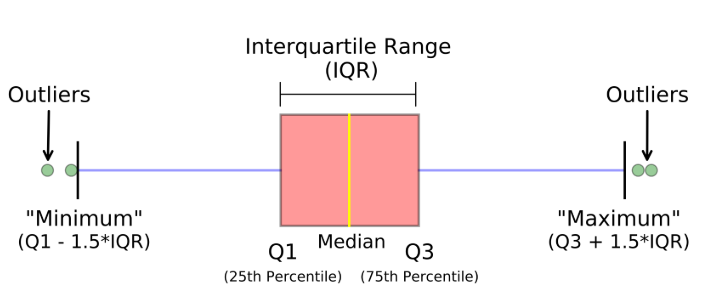

In [ ]:
data = []

for column in df.columns:
    data.append(go.Box(
        y=df[column],
        boxpoints='all', # all, outliers, suspectedoutliers
        boxmean=True
    ))

max_col = 2
out_filename = 'EDA - Box-Plot.html'
subplot_titles = [f'{x.title()}' for x in df.columns]

plot_subplots(data, max_col, out_filename, subplot_titles=subplot_titles)

### Violin-Plot

- Combination of Box-Plot & PDF
- Probability Density Function (PDF)
  - Used to specify the probability of the variable falling within a particular range of values, as opposed to taking on any one value.
  - It is given by the area under the density function but above the horizontal axis and between the lowest & greatest values of the range.

In [ ]:
data = []

for column in df.columns:
    data.append(go.Violin(
        y=df[column],
        box_visible=True,
        meanline_visible=True,
        points='all' # all, outliers, suspectedoutliers
    ))

max_col = 2
out_filename = 'EDA - Violin-Plot.html'
subplot_titles = [f'{x.title()}' for x in df.columns]

plot_subplots(data, max_col, out_filename, subplot_titles=subplot_titles)

## Bivariate Visualization

- Analyze 2 features at a time

### Pair-Plot

- Create nC2 plots where n is the number of features.
- nC2 Calculator: https://www.calculatorsoup.com/calculators/discretemathematics/combinations.php
- If there's many features, it is not practical to analyze all the pairs, therefore it is required to use PCA / t-SNE to perform dimensionality reduction, and then analyze the pair-plots.
- Reference: https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/2815/pair-plots/2/module-2-data-science-exploratory-data-analysis-and-data-visualization

In [ ]:
target_fields = ['target', 'target name']
target_column = 'target name'
columns = [x for x in df.columns if x not in target_fields]

data = []
dimensions = []

for column in [x for x in columns]:
    dimensions.append({
        'label': column,
        'values': df[column]
    })

data.append(go.Splom(
    dimensions=dimensions,
    showupperhalf=False,
    text=df[target_column],
    marker=dict(
        color=df[target_column].astype('category').cat.codes,
        opacity=.5
    )
))

title = 'EDA - Pair-Plot'
plot_graph(data, title, gridcolor=None, plot_bgcolor=None)

### Pair-Plot - Custom

In [ ]:
target_fields = ['target', 'target name']
target_column = 'target name'
columns = [x for x in df.columns if x not in target_fields]

data = []
axis_labels = []
colors = cl.scales['9']['qual']['Set1']

for y_index, y_column in enumerate(columns):
    for x_index, x_column in enumerate(columns):
        axis_labels.append((x_column, y_column))
        
        pair_data = []
        targets = []
        targets_x = []
        targets_y = []

        for target in df[target_column].unique():
            tmp_df = df[df[target_column] == target]

            targets.append(target)
            targets_x.append(tmp_df[x_column].values)
            targets_y.append(tmp_df[y_column].values)
        
        for index, target in enumerate(targets):
            pair_data.append(go.Scattergl(
                x = targets_x[index],
                y = targets_y[index],
                mode = 'markers',
                opacity = .5,
                name=target,
                legendgroup=target,
                marker=dict(
                    color=[colors[index] for _ in targets_x[index]]
                ),
                showlegend=y_index == 0 and x_index == 0
            ))

        data.append(pair_data)

max_col = len(columns)
out_filename = 'EDA - Pair-Plot - Custom.html'

nested_subplots(data, max_col, out_filename, axis_labels=axis_labels)

### Bivariate Histogram

- use PDF line to determine manually the correct cluster or classification error rate.
  - if there's overlapping between features of different target, then use the intersaction point of PDF.
- Reference: https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/2819/cdfcumulative-distribution-function/2/module-2-data-science-exploratory-data-analysis-and-data-visualization

In [ ]:
target_fields = ['target', 'target name']
target_column = 'target name'
columns = [x for x in df.columns if x not in target_fields]

fig_data = []

for column in columns:
    hist_data = []
    group_labels = []
    
    for target in df[target_column].unique():
        tmp_df = df[df[target_column] == target]

        hist_data.append(tmp_df[column])
        group_labels.append(target)

    fig = ff.create_distplot(hist_data, group_labels, show_rug=False, bin_size=.1)
    fig_data.append(fig['data'])
    
max_col = 2
out_filename = 'EDA - Bivariate Histogram.html'
subplot_titles = [f'{x.title()}' for x in columns]

nested_subplots(fig_data, max_col, out_filename, subplot_titles)

### Bivariate Histogram - Custom

In [ ]:
target_fields = ['target', 'target name']
target_column = 'target name'
columns = [x for x in df.columns if x not in target_fields]

data = []
colors = cl.scales['9']['qual']['Set1']

for col_index, column in enumerate(columns):
    hist_data = []
    targets = []
    targets_values = []
    
    for target in df[target_column].unique():
        tmp_df = df[df[target_column] == target]

        targets.append(target)
        targets_values.append(tmp_df[column].values)
        
    for index, values in enumerate(targets_values):
        # Histogram
        target = targets[index]
        
        # Determine bins size, .1 for fractional values and 1 for integer values
        size = 1 if len([x for x in values if x % 1 == 0]) == len(values) else .1
        
        hist_data.append(go.Histogram(
            x=values,
            opacity=.5,
            xbins=dict(
                size=size
            ),
            name=target,
            legendgroup=target,
            marker=dict(
                color=[colors[index] for _ in values]
            ),
            histnorm='probability density',
            showlegend=col_index == 0
        ))
        
    data.append(hist_data)
    
max_col = 2
out_filename = 'EDA - Bivariate Histogram - Custom.html'
subplot_titles = [f'{x.title()}' for x in columns]

nested_subplots(data, max_col, out_filename, subplot_titles)